In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys
sys.path.append('/home/hanwenli/work/2025/AL_SSL/')
from utils import fix_seed
from find_best_layer import best_layer_dict
from llm_models.models import LLMs
from hidden_state.generate import generate_dataset
from hidden_state.utils import split_dataset
from trainer import Trainer
import numpy as np

In [ ]:
fix_seed(40)
best_layer = 17
    
llm = LLMs('llama3', 8)
dataset, file_name = generate_dataset(llm, 'trivia_qa', layer_id=best_layer, save=True)
train_dataset, validation_dataset = split_dataset(dataset, int(0.8*len(dataset)), balance=False)

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

def split_by_kmeans_with_pca(data_list, n_select=100, pca_dim=128):
    """
    Selects `n_select` diverse samples from a list of dicts using PCA + KMeans.
    Each dict must contain a 'hidden_state' key with a high-dimensional vector.
    
    Parameters:
        data_list (list of dict): The original data.
        n_select (int): Number of samples to select.
        pca_dim (int): PCA dimension for reduction before clustering.
    
    Returns:
        list of dict: Subset of data_list, preserving original format.
    """
    vectors = np.array([item['hidden_state'] for item in data_list])

    pca = PCA(n_components=pca_dim)
    reduced_vectors = pca.fit_transform(vectors)

    kmeans = KMeans(n_clusters=n_select, n_init='auto')
    kmeans.fit(reduced_vectors)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    selected_indices = []
    for cluster_id in range(n_select):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_points = reduced_vectors[cluster_indices]
        center = centers[cluster_id]

        distances = np.linalg.norm(cluster_points - center, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        selected_indices.append(closest_idx)

    selected_data = [data_list[i] for i in selected_indices]
    remaining_data = [item for i, item in enumerate(data_list) if i not in selected_indices]
    return selected_data, remaining_data


In [ ]:
%%timeit -r 1
slected_data, remaining_data = split_by_kmeans_with_pca(train_dataset)

In [6]:
from sklearn.cluster import KMeans
import numpy as np

def split_by_kmeans_without_pca(data_list, n_select=100):
    """
    Split data into a representative subset and the remaining data using KMeans (no PCA).

    Parameters:
        data_list (list of dict): Input dataset, each dict must contain 'hidden_state'.
        n_select (int): Number of representative samples to select.

    Returns:
        selected_data (list of dict): Selected representative subset.
        remaining_data (list of dict): The rest of the dataset.
    """
    vectors = np.array([item['hidden_state'] for item in data_list])

    kmeans = KMeans(n_clusters=n_select, random_state=42, n_init='auto')
    kmeans.fit(vectors)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    selected_indices = []
    for cluster_id in range(n_select):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_vectors = vectors[cluster_indices]
        center = centers[cluster_id]

        distances = np.linalg.norm(cluster_vectors - center, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        selected_indices.append(closest_idx)

    selected_set = set(selected_indices)

    selected_data = [data_list[i] for i in selected_indices]
    remaining_data = [item for i, item in enumerate(data_list) if i not in selected_set]

    return selected_data, remaining_data

In [ ]:
%%timeit -r 1
slected_data, remaining_data = split_by_kmeans_without_pca(train_dataset)

In [ ]:
train_dataset[0]

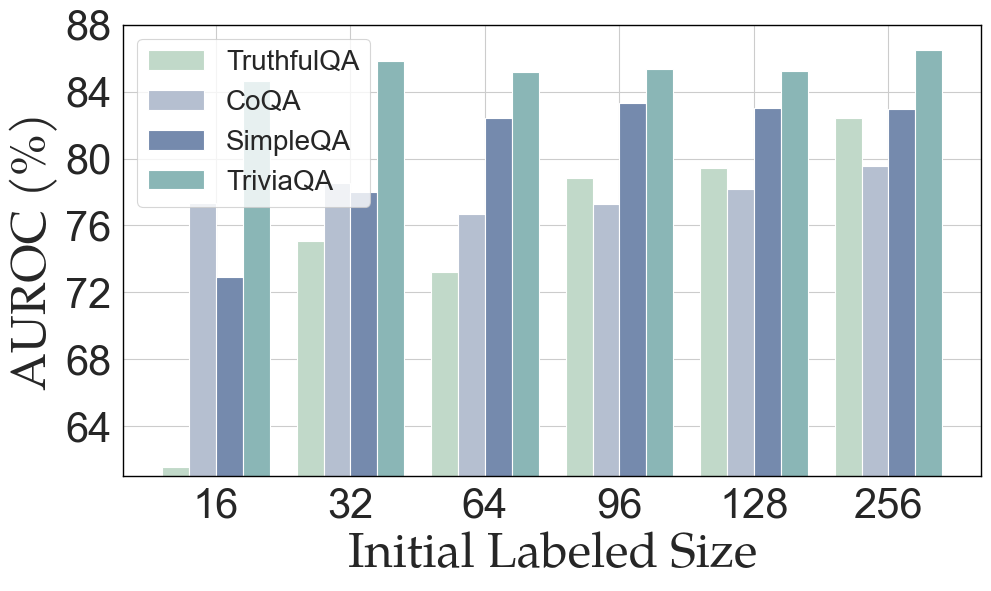

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import seaborn as sns
from matplotlib.ticker import MaxNLocator



# Read the data
df = pd.read_csv('/home/hanwenli/work/2025/AL_SSL/results_with_num_qwen.csv')
df = pd.read_csv('/home/hanwenli/work/2025/AL_SSL/results_with_num.csv')

# Use this to read from an actual file:
# df = pd.read_csv('your_filename.csv')
sns.set_theme(style="whitegrid", context="paper")

# Convert initial_labeled_size to numeric type if needed
df['initial_labeled_size'] = pd.to_numeric(df['initial_labeled_size'])
dataset_styles = {
    'truthful_qa': {'color': '#C4C4C4'},
    'simple_qa': {'color': '#778da9'},
    'coqa': {'color': '#3a6ea5'},
    'trivia_qa': {'color': '#1b263b'}
}

# Define the specific order for datasets (left to right)
dataset_order = ['truthful_qa', 'coqa', 'simple_qa', 'trivia_qa']
dataset_name = ['TruthfulQA', 'CoQA', 'SimpleQA', 'TriviaQA']

# Create a figure with sufficient size
plt.figure(figsize=(10, 6))

# For each dataset, create a bar chart
x_labels = sorted(df['initial_labeled_size'].unique())
n_datasets = len(dataset_order)
bar_width = 0.2  # Width of each bar

# Create positions for each group of bars
x = np.arange(len(x_labels))
colors = sns.color_palette('muted', len(dataset_order))
colors = ['#CEDCE9', '#82A4C8', '#4F7BA8', '#335372']
colors = ['#A9D9BB','#90B4CF','#337BAC','#4FB1B2']
# colors = ['#B5D9C2','#A3B9CF','#5482AC','#6DB3B4']
# colors = ['#D5E8F1','#ABD7DF','#CAEBE7','#A9D9BB']
colors = ['#C1D9C9','#B5BFD0','#758AAD','#8AB6B6']
# For each dataset, plot its bars at the appropriate positions
for i, dataset in enumerate(dataset_order):
    # Filter data for this dataset
    subset = df[df['dataset'] == dataset]
    
    # Sort by initial_labeled_size
    subset = subset.sort_values('initial_labeled_size')
    
    # Get positions for this dataset's bars (shifted based on dataset index)
    bar_positions = x + (i - n_datasets/2 + 0.5) * bar_width
    
    # Plot the bars
    plt.bar(
        bar_positions, 
        subset['auroc']*100,
        width=bar_width,
        label=dataset_name[i],
        color = colors[i]
    )

font_family = 'TeX Gyre Pagella'
# Set the x-axis labels and positions
plt.xticks(x, x_labels, fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Initial Labeled Size', fontsize=35, fontfamily=font_family)
plt.ylabel('AUROC (%)', fontsize=35, fontfamily=font_family)
# plt.title('Llama3-8B-Instruct', fontsize=40)

# Add grid for better readability
plt.ylim(61, 88)
# Set y-axis limits to focus on the relevant range
ax = plt.gca() # Or fig.add_subplot(111) if you created it that way
ax.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
# # Set the Y-axis to show only integer ticks

for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Add a legend
plt.legend(fontsize=20, loc='upper left')
# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('/home/hanwenli/work/2025/AL_SSL/results/experiments/pdf_results/auroc_with_labeled_num_llama3_color2.pdf', dpi=300, bbox_inches='tight')
# Display the chart
plt.show()

# To save the file, uncomment this line:
